# Examples of the 5-30 seconds rule

See [The 5-30 seconds rule for visualisations](https://impactful.engineering/blog/the-5-30-seconds-rule) blog post.

A visualisation should allow you to:
- Understand if things are on track in less than 5 seconds.
- Find out where they're not within 30 seconds.

## Generating fake data

In [74]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

weeks = [f"w{31 + i}" for i in range(12)]
services = ["Service_A", "Service_B", "Service_C", "Service_D", "Service_E", "Service_F", "Service_G", "Service_H"]
df = pd.DataFrame(index=services, columns=weeks)

for service in services:
    if service == "Service_A":  # Lower availability in the first few weeks
        df.loc[service] = [99.63, 99.35, 99.88] + [99.95] * 9
    elif service == "Service_B":  # Lower availability recently
        df.loc[service] = [99.95] * 9 + [99.9, 99.88, 99.85]
    else:
        df.loc[service] = [99.95 + np.random.uniform(-0.02, 0.02) for _ in range(12)]
df

,w31,w32,w33,w34,w35,w36,w37,w38,w39,w40,w41,w42
Service_A,99.63,99.35,99.88,99.95,99.95,99.95,99.95,99.95,99.95,99.95,99.95,99.95
Service_B,99.95,99.95,99.95,99.95,99.95,99.95,99.95,99.95,99.95,99.9,99.88,99.85
Service_C,99.941363,99.967061,99.947917,99.957127,99.939166,99.961577,99.934064,99.944442,99.949561,99.949037,99.964469,99.945654
Service_D,99.938113,99.952552,99.94628,99.96856,99.946577,99.940306,99.934273,99.95473,99.937821,99.961779,99.936267,99.939961
Service_E,99.933446,99.952829,99.932193,99.944588,99.952602,99.934693,99.933764,99.942063,99.967872,99.967117,99.933028,99.941947
Service_F,99.937197,99.963817,99.940935,99.938672,99.959061,99.938424,99.964832,99.961671,99.965333,99.949785,99.944066,99.93162
Service_G,99.960841,99.933546,99.965765,99.960578,99.930044,99.967861,99.962579,99.948723,99.935626,99.965019,99.949587,99.955243
Service_H,99.944913,99.968532,99.942927,99.934325,99.965063,99.93067,99.932605,99.962993,99.937078,99.965232,99.93526,99.948387


## Averaging services

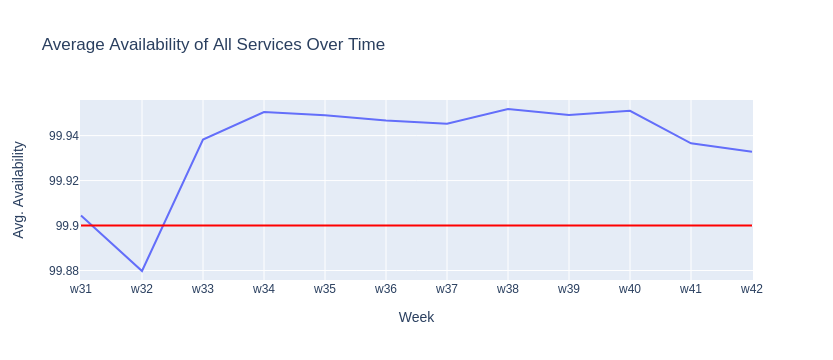

In [75]:
df_avg = pd.DataFrame()
df_avg['Average'] = df.mean(axis=0)
df_avg.reset_index()
fig = px.line(df_avg.reset_index(), x=weeks, y='Average', title='Average Availability of All Services Over Time')

fig.add_shape(
    go.layout.Shape(
        type="line",
        x0=weeks[0],
        x1=weeks[-1],
        y0=99.9,
        y1=99.9,
        line=dict(color="red", width=2),
    )
)

fig.update_xaxes(title_text='Week')
fig.update_yaxes(title_text='Avg. Availability')

fig.show()

## Stacked area chart

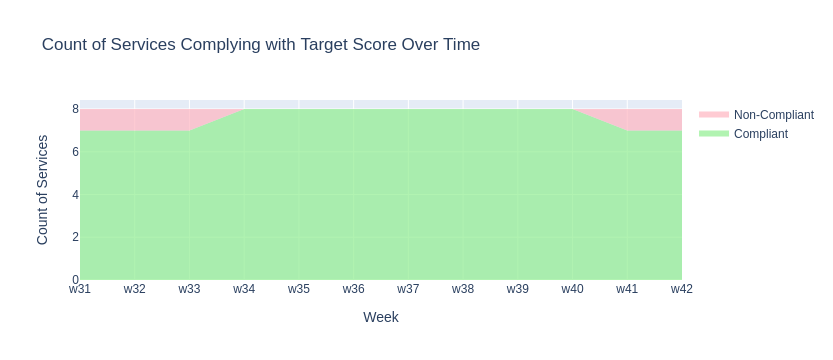

In [76]:
# Count the number of services that comply and don't comply with the target score for each week
compliant_count = (df >= 99.9).sum(axis=0)
non_compliant_count = (df < 99.9).sum(axis=0)

# Create a DataFrame for plotting
df_count = pd.DataFrame({
    'Week': weeks,
    'Compliant': compliant_count.values,
    'Non_Compliant': non_compliant_count.values
})

# Calculate the stacked values
df_count['Total'] = df_count['Compliant'] + df_count['Non_Compliant']

# Create the area chart using Plotly Express
fig = go.Figure()

# Add the compliant area (in pastel green, translucent)
fig.add_trace(go.Scatter(
    x=df_count['Week'], y=df_count['Compliant'],
    fill='tozeroy',
    mode='none',
    name='Compliant',
    fillcolor='rgba(144, 238, 144, 0.7)'
))

# Add the non-compliant area (in pastel red, translucent)
fig.add_trace(go.Scatter(
    x=df_count['Week'], y=df_count['Total'],
    fill='tonexty',
    mode='none',
    name='Non-Compliant',
    fillcolor='rgba(255, 182, 193, 0.7)'
))

# Add axis labels and title
fig.update_layout(
    title='Count of Services Complying with Target Score Over Time',
    xaxis_title='Week',
    yaxis_title='Count of Services'
)

# Show the figure
fig.show()

## Heatmap

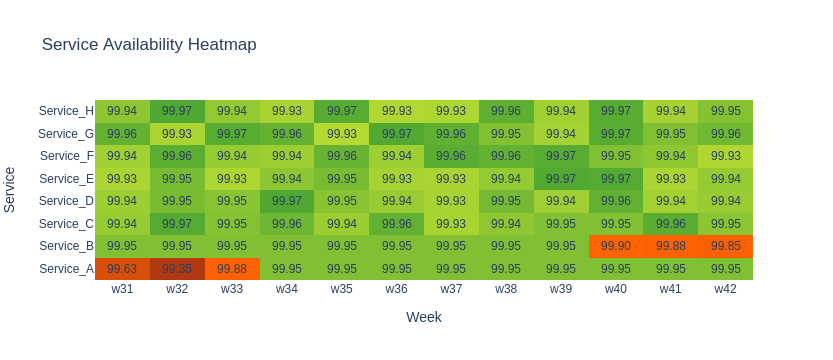

In [90]:
df_rounded = df.round(2)

colorscale = [
    [0, 'rgb(128,30,30)'],  # Black
    [0.99, 'rgb(128,30,30)'],  # Black
    [0.999, 'rgb(255,100,0)'],  # Red
    [0.999001, 'rgb(255,255,50)'],  # Yellow
    [1, 'rgb(0,128,50)'],  # Green
]

fig = go.Figure(data=go.Heatmap(
    z=df.values,
    x=weeks,
    y=services,
    colorscale=colorscale,
    zmin=0,
    zmax=100,
    hoverinfo='text',
    showscale=False
))

annotations = []
for i, row in enumerate(df_rounded.iterrows()):
    for j, val in enumerate(row[1]):
        annotations.append(
            dict(
                x=weeks[j],
                y=services[i],
                text="%.2f" % val,
                xref='x1',
                yref='y1',
                showarrow=False,
                font=dict(size=12)
            )
        )

fig.update_layout(
    title='Service Availability Heatmap',
    xaxis_title='Week',
    yaxis_title='Service',
    annotations=annotations
)

fig.show()